In [2]:
#Importing Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.constraints import max_norm as maxnorm
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation, Dense ,Dropout
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV

import os
import gzip
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import Counter
from PIL import Image
# from langdetect import detect
import re
import string



%matplotlib inline
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/')

Mounted at /content/drive


In [8]:
#Reading Data
calendar=pd.read_csv('calendar.csv.gz',compression='gzip')
rev_raw=pd.read_csv('reviews.csv.gz',compression='gzip')
list_raw=pd.read_csv('listings.csv.gz',compression='gzip')
reviews_summ=pd.read_csv('reviews.csv')
listings_summ=pd.read_csv('listings.csv')

#### First Look at Data

In [ ]:
print("Calendar Database has {} observations and {} columns (attributes).".format(calendar.shape[0],calendar.shape[1]))
print("Raw Reviews Database has {} observations and {} columns (attributes).".format(rev_raw.shape[0],rev_raw.shape[1]))
print("Raw Listings Database has {} observations and {} columns (attributes).".format(list_raw.shape[0],list_raw.shape[1]))
print("Review Summary Database has {} observations and {} columns (attributes).".format(reviews_summ.shape[0],reviews_summ.shape[1]))
print("Listing Summary Database has {} observations and {} columns (attributes).".format(listings_summ.shape[0],listings_summ.shape[1]))


Calendar Database has 27935194 observations and 8 columns (attributes).
Raw Reviews Database has 1163373 observations and 8 columns (attributes).
Raw Listings Database has 76534 observations and 7 columns (attributes).
Review Summary Database has 1163886 observations and 2 columns (attributes).
Listing Summary Database has 76534 observations and 9 columns (attributes).


In [ ]:
calendar.head(2)

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,100326,2021-02-13,f,$33.00,$33.00,2.0,10.0
1,13913,2021-02-12,t,$40.00,$40.00,1.0,29.0


In [ ]:
calendar.listing_id.nunique()

76531

In [ ]:
list_raw.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

In [ ]:
rev_raw.head(2)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,13913,80770,2010-08-18,177109,Michael,My girlfriend and I hadn't known Alina before ...
1,13913,367568,2011-07-11,19835707,Mathias,Alina was a really good host. The flat is clea...


In [ ]:
listings_summ.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,40,1,21,2020-02-22,0.16,2,365
1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,75,10,89,2020-03-16,0.66,1,189


Exploring Listing Data:

In [ ]:
print("\nMissing values in each column:\n{}".format(listings_summ.isnull().sum()*100/listings_summ.shape[0]))
print("\nData Types:\n{}".format(listings_summ.dtypes))


Missing values in each column:
id                                  0.000000
name                                0.031359
host_id                             0.000000
host_name                           0.060104
neighbourhood_group               100.000000
neighbourhood                       0.000000
latitude                            0.000000
longitude                           0.000000
room_type                           0.000000
price                               0.000000
minimum_nights                      0.000000
number_of_reviews                   0.000000
last_review                        28.998876
reviews_per_month                  28.998876
calculated_host_listings_count      0.000000
availability_365                    0.000000
dtype: float64

Data Types:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourh

#### *Insights* :  
neighbourhood_group is 100% null, so we'll drop it.  
Will treat last_review and reviews_per_month as there may be no reviews for those listings, so reviews per month NaN imputed by 0 while ignoring date column last review  
name missing values can be ignored as same information is in id  
similarly host_name nulls are being ignored because we have host_id  

In [ ]:
listings_summ.drop('neighbourhood_group',axis=1,inplace=True)
listings_summ.reviews_per_month.fillna(0,inplace=True)

### Exploratory Data Analysis

In [ ]:
listings_summ.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.653400e+04,7.653400e+04,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000
mean,2.608547e+07,9.737649e+07,51.510066,-0.128113,113.899051,5.308582,15.207437,0.405882,20.896621,118.742154
std,1.353230e+07,1.026857e+08,0.047620,0.094883,313.830681,23.053843,35.431784,0.737085,99.725744,143.842762
min,1.391300e+04,2.010000e+03,51.297330,-0.510220,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.526331e+07,1.636504e+07,51.484460,-0.188308,42.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2.624784e+07,5.012855e+07,51.514250,-0.125730,75.000000,2.000000,3.000000,0.130000,1.000000,42.000000
75%,3.833904e+07,1.567602e+08,51.539520,-0.069172,120.000000,4.000000,14.000000,0.510000,4.000000,252.000000
max,4.810299e+07,3.876413e+08,51.679980,0.288570,17746.000000,1125.000000,821.000000,26.310000,872.000000,365.000000


In [ ]:
n_unique = listings_summ.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
id                                76534
name                              74359
host_id                           50764
host_name                         14244
neighbourhood                        33
latitude                          20359
longitude                         31336
room_type                             4
price                               868
minimum_nights                      124
number_of_reviews                   403
last_review                        2285
reviews_per_month                   649
calculated_host_listings_count       71
availability_365                    366
dtype: int64


In [ ]:
print("Unique values in each categorical column:\n")
for col in listings_summ.select_dtypes(include=[object]):
    print(col,":", listings_summ[col].unique())

Unique values in each categorical column:

name : ['Holiday London DB Room Let-on going'
 'Bright Chelsea  Apartment. Chelsea!'
 'Superb 3-Bed/2 Bath & Wifi: Trendy W1' ...
 'Luxury Manhattan 2 Bed Battersea'
 'GuestReady - Lux Central 2BR Garden Flat in Fitzrovia, 4 guests'
 'Luxury Two bed by the US Embassy']
host_name : ['Alina' 'Philippa' 'Liz' ... 'AJay' 'Sloanes' 'Khadiza']
neighbourhood : ['Islington' 'Kensington and Chelsea' 'Westminster'
 'Hammersmith and Fulham' 'Barnet' 'Hounslow' 'Richmond upon Thames'
 'Haringey' 'Hackney' 'Southwark' 'Croydon' 'Waltham Forest' 'Brent'
 'Camden' 'Newham' 'Tower Hamlets' 'Redbridge' 'Lambeth' 'Merton'
 'Lewisham' 'Wandsworth' 'Bromley' 'Havering' 'Greenwich' 'Ealing'
 'Enfield' 'Barking and Dagenham' 'Hillingdon' 'Harrow'
 'Kingston upon Thames' 'Bexley' 'City of London' 'Sutton']
room_type : ['Private room' 'Entire home/apt' 'Hotel room' 'Shared room']
last_review : ['2020-02-22' '2020-03-16' '2019-11-02' ... '2020-06-21' '2020-06-25'
 '20

#### Univariate Analysis

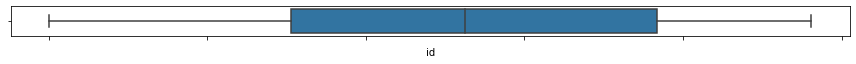

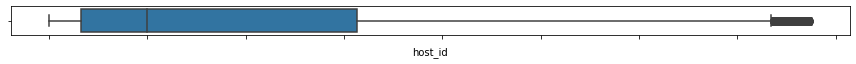

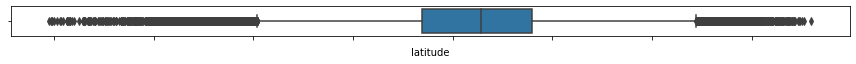

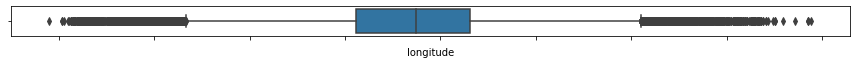

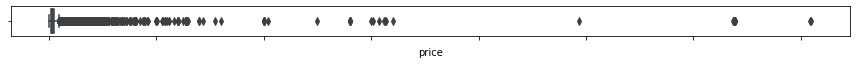

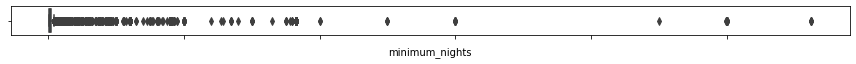

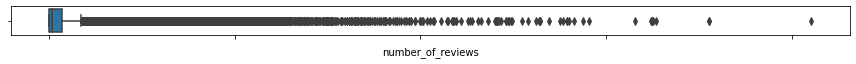

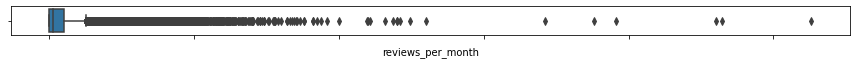

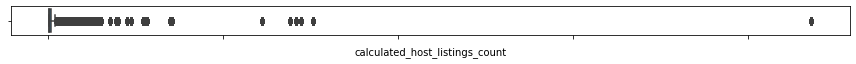

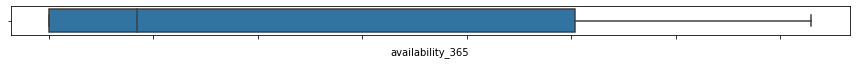

In [ ]:
def boxes(x,data,h=None,r=30):                   #univariate analysis of numerical variables
    fig, ax = plt.subplots(figsize=(12,1))
    box = sns.boxplot(x=x, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()
    plt.savefig('v'+x+'.png', format='png', dpi=1200)
for col in listings_summ.select_dtypes(exclude=[object]):
    boxes(col,listings_summ)

Price,No. of Reviews, Minimum_nights,Reviews_per_month, calculated_host_listings_count are all highly skewed variables.

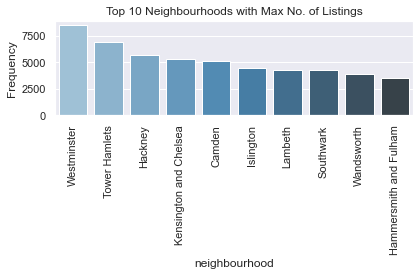

In [ ]:
sns.set()
top10_neigh=listings_summ.groupby('neighbourhood',as_index=False).count()[['neighbourhood','id']].sort_values(by='id',ascending=False).iloc[0:10]
v1=sns.barplot(top10_neigh.neighbourhood,top10_neigh.id,palette='Blues_d')
v1.set_title('Top 10 Neighbourhoods with Max No. of Listings')
v1.set_ylabel('Frequency')
v1.set_xticklabels(v1.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig('v1.png', format='png', dpi=1200)

plt.show()

Westminster has the most amount of listings (8000+)

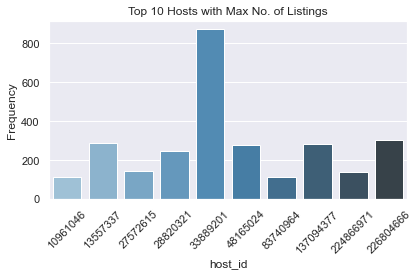

In [ ]:
sns.set()
top10_host=listings_summ.groupby('host_id',as_index=False).count()[['host_id','id']].sort_values(by='id',ascending=False).iloc[0:10].reset_index()
v1=sns.barplot(top10_host.host_id,top10_host.id,palette='Blues_d')
v1.set_title('Top 10 Hosts with Max No. of Listings')
v1.set_xticklabels(v1.get_xticklabels(), rotation=45)
v1.set_ylabel('Frequency')
plt.tight_layout()
plt.savefig('v2.png', format='png', dpi=1200)
plt.show()

Host 33889201 has by far outmatched all other hosts with 800+ listings!

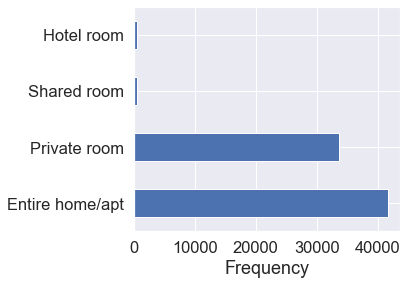

In [ ]:
sns.set(font_scale=1.5)
# plt.figure(figsize=[10,10])
listings_summ.room_type.value_counts().plot(kind='barh')
plt.tight_layout()
plt.xlabel('Frequency')
import matplotlib
matplotlib.rcParams.update({'font.size': 45})
plt.savefig('v3.png', format='png', dpi=1200)
plt.show()

Most Listings are for Entire home/ apt and private rooms

#### Bivariate Analysis:


In [ ]:
listings_summ[['room_type','price']].groupby('room_type').describe().T

room_type    Entire home/apt  Hotel room  Private room  Shared room
price count     41633.000000  559.000000  33734.000000   608.000000
      mean        157.257464  119.881932     61.213612    62.592105
      std         392.384574  103.313475    167.018618   109.984295
      min           8.000000    0.000000      0.000000     7.000000
      25%          79.000000   68.000000     30.000000    20.000000
      50%         108.000000   95.000000     40.000000    33.500000
      75%         163.000000  151.000000     59.000000    57.000000
      max       17746.000000  999.000000   8000.000000  1260.000000

In [ ]:
temp=listings_summ[listings_summ.price<500]

Clearly there are extreme values, so let's remove them for a better visualzation

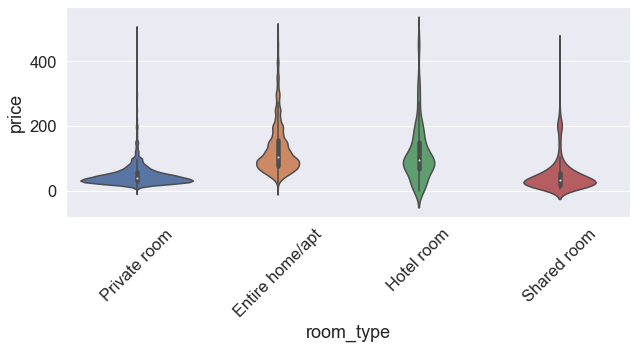

In [ ]:
def boxes(x,y,data,h=None,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.violinplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.tight_layout()
boxes("room_type","price",temp)
plt.savefig('v5.png',dpi=1200)

Hotel rooms have the highest range in prices, closely followed by Entire home/apt.  
In general,Hotel rooms and Entire home/apt are more expensive than Shared or Private rooms as expected.

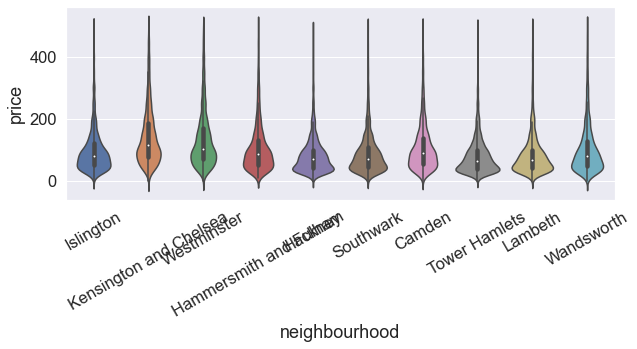

In [ ]:
temp2=temp[temp.neighbourhood.isin(top10_neigh.neighbourhood)]
boxes("neighbourhood","price",temp2,r=30)

Among the Top 10 neighbourhoods with most listings, Kensington and Chelsea is most expensive and all of them offer similar price ranges 

In [ ]:
listings_summ.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.653400e+04,7.653400e+04,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000,76534.000000
mean,2.608547e+07,9.737649e+07,51.510066,-0.128113,113.899051,5.308582,15.207437,0.405882,20.896621,118.742154
std,1.353230e+07,1.026857e+08,0.047620,0.094883,313.830681,23.053843,35.431784,0.737085,99.725744,143.842762
min,1.391300e+04,2.010000e+03,51.297330,-0.510220,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,1.526331e+07,1.636504e+07,51.484460,-0.188308,42.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,2.624784e+07,5.012855e+07,51.514250,-0.125730,75.000000,2.000000,3.000000,0.130000,1.000000,42.000000
75%,3.833904e+07,1.567602e+08,51.539520,-0.069172,120.000000,4.000000,14.000000,0.510000,4.000000,252.000000
max,4.810299e+07,3.876413e+08,51.679980,0.288570,17746.000000,1125.000000,821.000000,26.310000,872.000000,365.000000


In [ ]:
map = plt.imread('map.JPG')
BBox = ((listings_summ.longitude.min(),   listings_summ.longitude.max(),      
         listings_summ.latitude.min(), listings_summ.latitude.max()))

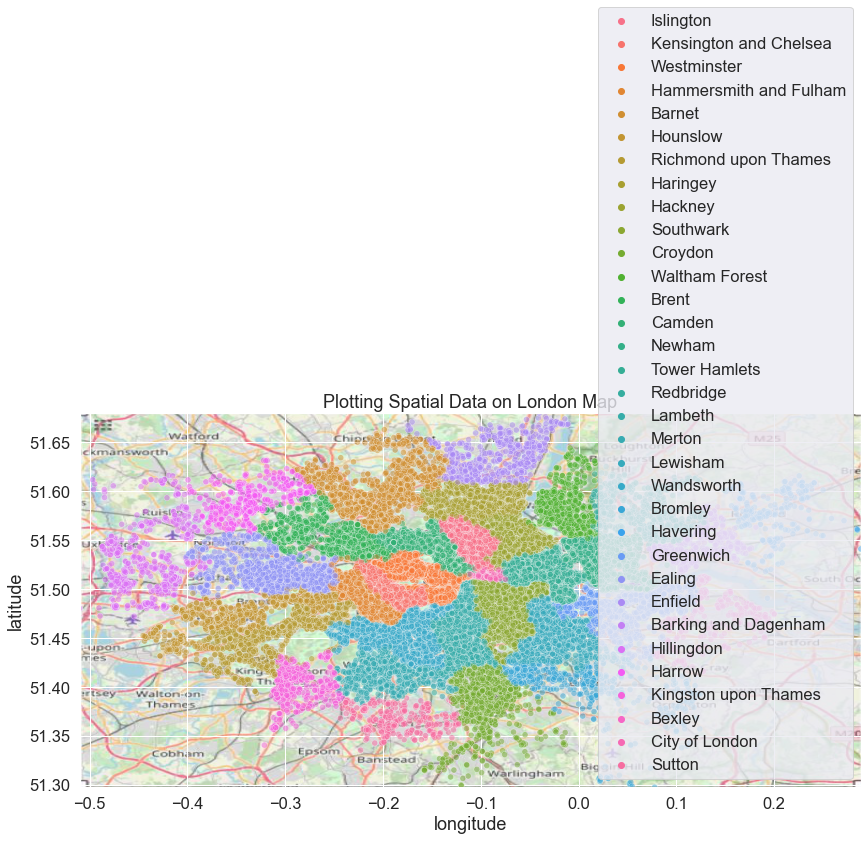

In [ ]:
plt.figure(figsize=(14,14))
plt.imshow(map,extent=BBox)
ax=plt.gca()
sns.scatterplot(x='longitude',y='latitude',hue='neighbourhood',c=listings_summ.price,data=listings_summ,ax=ax,alpha=0.5)
ax.set_title('Plotting Spatial Data on London Map')
plt.legend()
plt.show()

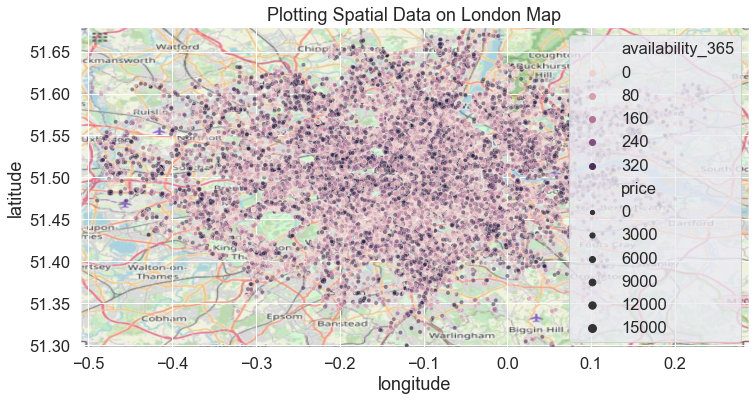

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(map,extent=BBox)
ax=plt.gca()
sns.scatterplot(x='longitude',y='latitude',hue='availability_365',data=listings_summ,ax=ax,size=listings_summ.price,alpha=0.5)
ax.set_title('Plotting Spatial Data on London Map')
plt.savefig('v6.png',dpi=1200)
plt.legend()
plt.show()

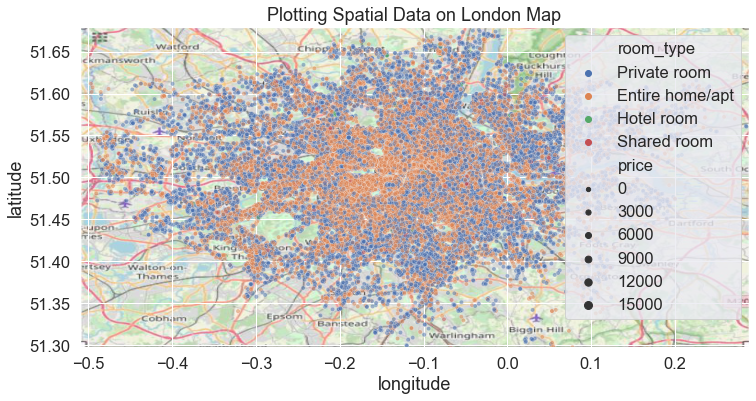

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(map,extent=BBox)
ax=plt.gca()
sns.scatterplot(x='longitude',y='latitude',hue='room_type',data=listings_summ,ax=ax,size=listings_summ.price,alpha=0.5)
ax.set_title('Plotting Spatial Data on London Map')
plt.legend()
plt.show()

Let's look at Reviews now:

In [ ]:
n_unique = rev_raw.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
listing_id         54340
id               1163886
date                3718
reviewer_id       983586
reviewer_name     120501
comments         1116543
dtype: int64


In [ ]:
rev_raw.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,13913,80770,2010-08-18,177109,Michael,My girlfriend and I hadn't known Alina before ...
1,13913,367568,2011-07-11,19835707,Mathias,Alina was a really good host. The flat is clea...
2,13913,529579,2011-09-13,1110304,Kristin,Alina is an amazing host. She made me feel rig...
3,13913,595481,2011-10-03,1216358,Camilla,"Alina's place is so nice, the room is big and ..."
4,13913,612947,2011-10-09,490840,Jorik,"Nice location in Islington area, good for shor..."


In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

The use of an exclamation mark(!), increases the magnitude of the intensity without modifying the semantic orientation.Using upper case letters to emphasize a sentiment-relevant word in the presence of other non-capitalized words, increases the magnitude of the sentiment intensity.Degree Modifiers - Also called intensifiers, they impact the sentiment intensity by either increasing or decreasing the intensity. Eg- adjectives. Use of conjunctions like “but” signals a shift in sentiment polarity, with the sentiment of the text following the conjunction being dominant.  
By examining the tri-gram preceding a sentiment-laden lexical feature, we catch nearly 90% of cases where negation flips the polarity of the text. A negated sentence would be “The food here isn’t really all that great”.  
VADER performs very well with emojis, slangs and acronyms in sentences.

In [ ]:
rev_raw.isnull().sum()*100/rev_raw.shape[0]   #Dropping 0.04 % empty comments

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000086
comments         0.043991
dtype: float64

In [ ]:
rev_raw.dropna(inplace=True)

In [ ]:
def language_detection(text):
    try:
        return detect(text)
    except:
        return None
    

In [ ]:
%%time
rev_raw['language'] = rev_raw['comments'].apply(language_detection)

In [ ]:
# rev_raw=pd.read_csv('raw_rev.csv')

In [ ]:
sns.set()
rev_raw.language.value_counts(normalize=True)[0:3].sort_values()

es    0.021168
fr    0.043639
en    0.873329
Name: language, dtype: float64

In [ ]:
rev_raw.language.nunique()

46

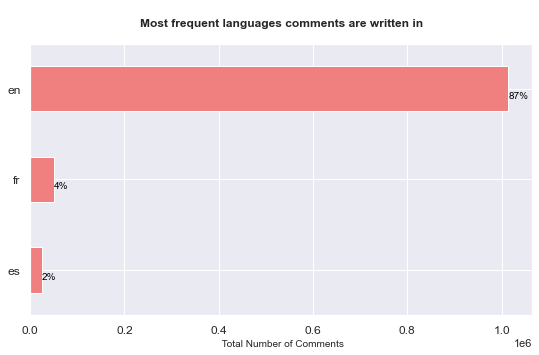

In [ ]:
# ax = df.language.value_counts(normalize=True).head(6).sort_values().plot(kind='barh', figsize=(9,5));
ax = rev_raw.language.value_counts().head(3).plot(kind='barh', figsize=(9,5), color="lightcoral", 
                                             fontsize=12);

ax.set_title("\nMost frequent languages comments are written in\n", 
             fontsize=12, fontweight='bold')
ax.set_xlabel(" Total Number of Comments", fontsize=10)
# ax.set_yticklabels(['English', 'German', 'French', 'Spanish', 'Italian', 'Dutch'])

# create a list to collect the plt.patches data
totals = []
# find the ind. values and append to list
for i in ax.patches:
    totals.append(i.get_width())
# get total
total = sum(totals)
lb=['87%','4%','2%']
c=0
# set individual bar labels using above list
for i in ax.patches:
    ax.text(x=i.get_width(), y=i.get_y()+.35, 
            s=lb[c], 
            fontsize=10, color='black')
    c+=1
# invert for largest on top 
ax.invert_yaxis()
plt.savefig('v7.png', format='png', dpi=1200)


In [ ]:
rev_raw_en=rev_raw[rev_raw.language=='en']          #Only using English comments for Vader
rev_raw_en['scores'] = rev_raw_en['comments'].apply(lambda review: analyser.polarity_scores(review))

In [ ]:
rev_raw_en['Sentiment_Score']=rev_raw_en.scores.apply(lambda x:x['compound'])

In [ ]:
per=rev_raw_en.Sentiment_Score.describe(percentiles=[.01 ,.015,0.045,.05, .1, .2, .3, .4, .5, .6, .7, .8, .9])
per

count    1.014338e+06
mean     8.249174e-01
std      2.638443e-01
min     -9.985000e-01
1%      -2.975000e-01
1.5%     0.000000e+00
4.5%     1.236330e-01
5%       2.714000e-01
10%      5.719000e-01
20%      7.650000e-01
30%      8.464000e-01
40%      8.928000e-01
50%      9.216000e-01
60%      9.423000e-01
70%      9.582000e-01
80%      9.709000e-01
90%      9.822000e-01
max      9.997000e-01
Name: Sentiment_Score, dtype: float64

In [ ]:
condn=[(rev_raw_en.Sentiment_Score<=per['1.5%']),
        (rev_raw_en.Sentiment_Score>per['1.5%']) & (rev_raw_en.Sentiment_Score<per['20%']),
       (rev_raw_en.Sentiment_Score>=per['20%'])]
choice=['neg','mid','pos']
rev_raw_en['Score_Bckt']=np.select(condn,choice)
rev_raw_en.Score_Bckt.value_counts(normalize=True)

pos    0.802437
mid    0.154423
neg    0.043140
Name: Score_Bckt, dtype: float64

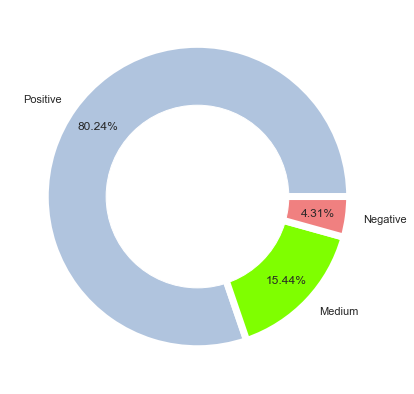

In [ ]:
plt.pie(rev_raw_en.Score_Bckt.value_counts(normalize=True),labels = ['Positive', 'Medium','Negative'], 
        colors=['lightsteelblue', 'chartreuse','lightcoral'], 
        autopct='%.2f%%', pctdistance=0.8,
        wedgeprops={'linewidth':7, 'edgecolor':'white' })
my_circle = plt.Circle((0,0), 0.6, color='white')

fig = plt.gcf()
fig.set_size_inches(7,7)
fig.gca().add_artist(my_circle)
plt.savefig('v8.png', format='png', dpi=1200)
plt.show()


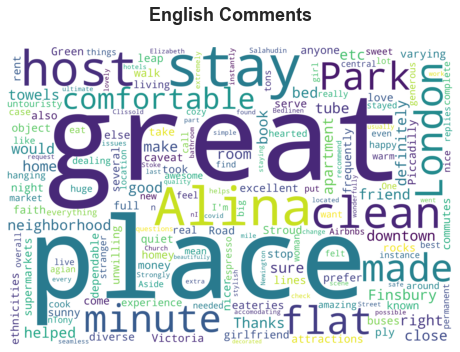

In [ ]:
import nltk
# wrap the plotting in a function for easier access
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.savefig('v10.png', format='png', dpi=1200)
    plt.show()
positive=rev_raw_en[rev_raw_en.Sentiment_Score>=0.95]
wordcloud = WordCloud(max_font_size=None, max_words=200, background_color="white", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(positive.comments.values))

plot_wordcloud(wordcloud, 'English')


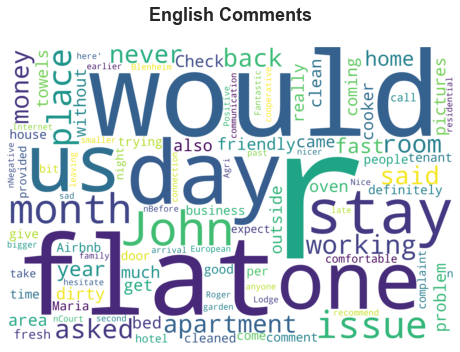

In [ ]:
def plot_wordcloud(wordcloud, language):
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(language + ' Comments\n', fontsize=18, fontweight='bold')
    plt.savefig('v9.png', format='png', dpi=1200)
    plt.show()

negative=rev_raw_en[rev_raw_en.Sentiment_Score<-0.0]
wordcloud = WordCloud(max_font_size=None, max_words=100, background_color="white", 
                      width=3000, height=2000,
                      stopwords=stopwords.words('english')).generate(str(negative.comments.values))

plot_wordcloud(wordcloud, 'English')

In [ ]:
g=rev_raw_en.groupby('listing_id',as_index=False)
g.count()['comments'].describe()            #distribution of no. of reviews per listings 

count    53307.000000
mean        19.028233
std         35.108890
min          1.000000
25%          2.000000
50%          7.000000
75%         20.000000
max        687.000000
Name: comments, dtype: float64

In [ ]:

cnts=g.count()[['listing_id','comments']]
pop_listings=cnts[cnts.comments>=50]['listing_id']
pop_list_rev=rev_raw_en[rev_raw_en.listing_id.isin(pop_listings)]
g=pop_list_rev.groupby('listing_id',as_index=False)
best=g.mean().sort_values('Sentiment_Score',ascending=False)[['listing_id','Sentiment_Score']].head(1)
worst=g.mean().sort_values('Sentiment_Score',ascending=True)[['listing_id','Sentiment_Score']].head(1)


In [ ]:
print('Highest scored listing:\n',best)

Highest scored listing:
     listing_id  Sentiment_Score
53       99241         0.964451


In [ ]:
print('Lowest scored listing:\n',worst)

Lowest scored listing:
       listing_id  Sentiment_Score
5121    35923663         0.458667


In [ ]:
g=rev_raw_en.groupby('listing_id',as_index=False)
cnts=g.count()[['listing_id','comments']]
cnts.sort_values('comments',ascending=False).iloc[0]       #Most reviewed listing

listing_id    1436172
comments          687
Name: 1777, dtype: int64

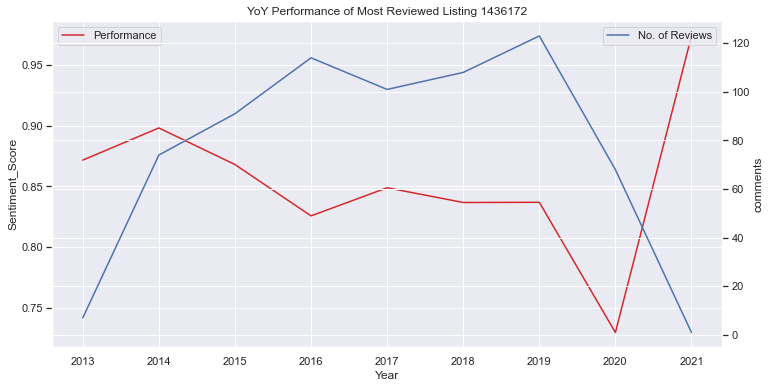

In [ ]:
time_df=rev_raw_en[rev_raw_en.listing_id==1436172]
time_df['Year']=pd.to_datetime(time_df.date).dt.year
g=time_df.groupby('Year',as_index=False).mean()[['Year','Sentiment_Score']]

fig, ax1 = plt.subplots(figsize=(12,6))
color='tab:red'
ax1 = sns.set_style(style=None, rc=None )
ax1=sns.lineplot(x='Year',y='Sentiment_Score',data=g,color=color)
g2=time_df.groupby('Year',as_index=False).count()[['Year','comments']]

ax2 = ax1.twinx()

ax2=sns.lineplot(x='Year',y='comments',data=g2,palette='summer')
ax1.legend(['Performance'])
ax2.legend(['No. of Reviews'])
plt.title('YoY Performance of Most Reviewed Listing 1436172')
plt.savefig('v11.png', format='png', dpi=1200)

plt.show()


In [ ]:
rev_raw_en=pd.merge(rev_raw_en,listings_summ[['id','host_name']],left_on='listing_id',right_on='id')

In [ ]:
g=rev_raw_en.groupby('host_name',as_index=False)

cnts=g.count()[['host_name','comments']]
pop_hosts=cnts[cnts.comments>=50]['host_name']
pop_host_rev=rev_raw_en[rev_raw_en.host_name.isin(pop_hosts)]
g=pop_host_rev.groupby('host_name',as_index=False)
best=g.mean().sort_values('Sentiment_Score',ascending=False)[['host_name','Sentiment_Score']].head(1)
worst=g.mean().sort_values('Sentiment_Score',ascending=True)[['host_name','Sentiment_Score']].head(1)


In [ ]:
best,worst

(                host_name  Sentiment_Score
 2754  The Portobello Room         0.964451,
                      host_name  Sentiment_Score
 2691  TLK Apartments - Peckham         0.443286)

## Price Prediction

In [ ]:
print("\nMissing values in each column:\n{}".format(calendar.isnull().sum()*100/calendar.shape[0]))
print("\nData Types:\n{}".format(calendar.dtypes))


Missing values in each column:
listing_id        0.000000
date              0.000000
available         0.000000
price             0.001836
adjusted_price    0.001836
minimum_nights    0.008706
maximum_nights    0.008706
dtype: float64

Data Types:
listing_id          int64
date               object
available          object
price              object
adjusted_price     object
minimum_nights    float64
maximum_nights    float64
dtype: object


In [ ]:
calendar.shape

(27935194, 7)

In [ ]:
calendar['Price']=calendar.price.str.replace("$",'')
calendar['Price']=calendar.Price.str.replace(",",'')


In [ ]:
calendar['Price']=calendar['Price'].astype('float')

In [ ]:
pd.to_datetime(cal.date).describe()

count                     365
unique                    365
top       2021-02-13 00:00:00
freq                        1
first     2021-02-13 00:00:00
last      2022-02-12 00:00:00
Name: date, dtype: object

In [ ]:
cal=calendar[calendar.listing_id==1436172]
cal['Year']=pd.to_datetime(cal.date).dt.year
g=cal.groupby('Year',as_index=False).mean()[['Year','Price']]
g

,Year,Price
0,2021,65.847826
1,2022,66.000000


In [ ]:
pd.to_datetime(rev_raw[rev_raw.listing_id==1436172].date).describe()

count                     819
unique                    809
top       2015-10-24 00:00:00
freq                        2
first     2013-09-16 00:00:00
last      2021-01-28 00:00:00
Name: date, dtype: object

In [ ]:
list_raw=list_raw[['id','host_is_superhost',
       'host_has_profile_pic', 'host_identity_verified','accommodates','instant_bookable','beds']]
listings_summ=listings_summ[['id','neighbourhood','room_type','minimum_nights','number_of_reviews',
               'reviews_per_month','calculated_host_listings_count','availability_365','price']]

In [ ]:
df=pd.merge(list_raw,listings_summ,on='id')

In [ ]:
df.isnull().sum()*100/df.shape[0]

id                                0.000000
host_is_superhost                 0.060104
host_has_profile_pic              0.060104
host_identity_verified            0.060104
accommodates                      0.000000
instant_bookable                  0.000000
beds                              1.592756
neighbourhood                     0.000000
room_type                         0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
reviews_per_month                 0.000000
calculated_host_listings_count    0.000000
availability_365                  0.000000
price                             0.000000
dtype: float64

In [ ]:
df=df.dropna()

In [ ]:
#Feature engineering - Added column
mean_score=rev_raw_en.groupby('listing_id',as_index=False).mean()[['listing_id','Sentiment_Score']]

In [ ]:
df=pd.merge(df,mean_score,left_on='id',right_on='listing_id')   #Working on listings with English comments only

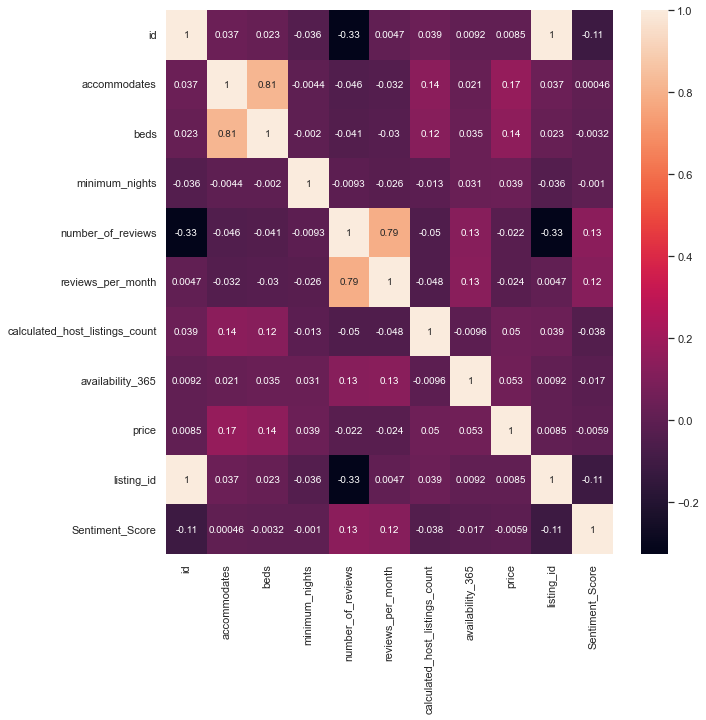

In [ ]:
corrmat=df.corr()         #Correlation matrix
features=corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(df[features].corr(),annot=True )

In [ ]:
df=df.drop(['number_of_reviews','beds','id','listing_id'],axis=1)   #Removing multicollinearity

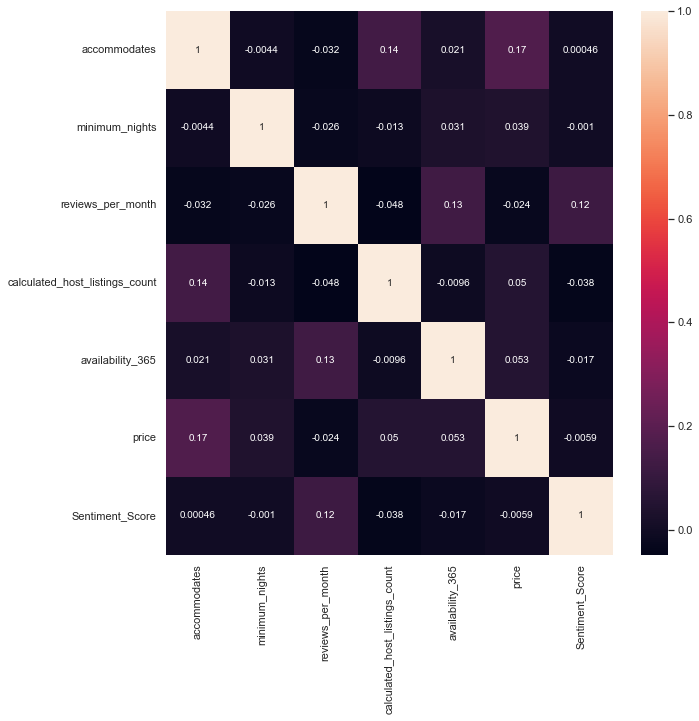

In [ ]:
corrmat=df.corr()         #Correlation matrix
features=corrmat.index
plt.figure(figsize=(10,10))
g=sns.heatmap(df[features].corr(),annot=True )

In [ ]:
X=df.drop(['price'],axis=1)
y=df.price

In [ ]:
#Checking for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
X=pd.get_dummies(X,drop_first=True)
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data

,feature,VIF
0,accommodates,5.179786
1,minimum_nights,1.054460
2,reviews_per_month,1.732882
3,calculated_host_listings_count,1.094398
4,availability_365,1.780633
5,Sentiment_Score,11.242662
6,host_is_superhost_t,1.387626
7,host_has_profile_pic_t,154.937926
8,host_identity_verified_t,5.453985
9,instant_bookable_t,1.591225


In [ ]:
X=X.drop('host_has_profile_pic_t',axis=1)       #Removing highly multicollinear variable

In [ ]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data

,feature,VIF
0,accommodates,5.099284
1,minimum_nights,1.054347
2,reviews_per_month,1.732678
3,calculated_host_listings_count,1.094343
4,availability_365,1.778479
5,Sentiment_Score,11.009653
6,host_is_superhost_t,1.387522
7,host_identity_verified_t,5.405053
8,instant_bookable_t,1.588147
9,neighbourhood_Barnet,1.378152


#### Model Selection

In [3]:
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [4]:
# X.to_csv('X.csv')
X=pd.read_csv('X.csv')
y=pd.read_csv('y.csv')
X=X.drop('Unnamed: 0',axis=1)
y=y.drop('Unnamed: 0',axis=1)

# y.to_csv('y.csv')

In [16]:
#Preprocessing
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test=scaler.transform(X_test)

In [9]:
#Model Experimentation
def give_me_best(X_train,y_train,X_test,y_test,seed=42):
    train_acc=[]
    test_acc=[]
    model=[]
    
    print('Training SGD\n')
    sgd = SGDRegressor(random_state=seed)
    sgd.fit(X_train, y_train)
    y_pred_train = sgd.predict(X_train)
    train_acc.append(mean_squared_error(y_train,y_pred_train))
    y_pred_test = sgd.predict(X_test)
    test_acc.append(mean_squared_error(y_test,y_pred_test))
    model.append(sgd)
    print('SGD Regressor Done!\n')
    
    print('\nTraining RF\n')
    rf=RandomForestRegressor(n_estimators=300,random_state=seed)
    rf.fit(X_train,y_train)
    y_pred_train = rf.predict(X_train)
    train_acc.append(mean_squared_error(y_train,y_pred_train))
    y_pred_test = rf.predict(X_test)
    test_acc.append(mean_squared_error(y_test,y_pred_test))
    model.append(rf)
    print('Random Forests Done!\n')
    
    
    print('\nTraining XGBoost\n')
    xg=XGBRegressor(n_estimators=300,random_state=seed)
    xg.fit(X_train,y_train)
    y_pred_train = xg.predict(X_train)
    train_acc.append(mean_squared_error(y_train,y_pred_train))
    y_pred_test = xg.predict(X_test)
    test_acc.append(mean_squared_error(y_test,y_pred_test))
    model.append(xg)
    print('XG Boost Done!\n')
    
    train_acc=np.sqrt(train_acc)
    test_acc=np.sqrt(test_acc)
    print('Lowest RMSE is '+str(pd.Series(test_acc).min())+' by following model:\n')
    temp=pd.DataFrame([model,train_acc,test_acc],index=['Model','Train_RMSE','Validation_RMSE']).T
    print(temp[temp.Validation_RMSE==temp.Validation_RMSE.min()]['Model'])
      
    return temp

In [10]:
best=give_me_best(X_train,y_train,X_test,y_test)

Training SGD

SGD Regressor Done!


Training RF

Random Forests Done!


Training XGBoost

[05:16:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XG Boost Done!

Lowest RMSE is 266.5185353829023 by following model:

1    (DecisionTreeRegressor(ccp_alpha=0.0, criterio...
Name: Model, dtype: object


In [12]:
best

,Model,Train_RMSE,Validation_RMSE
0,"SGDRegressor(alpha=0.0001, average=False, earl...",311.03,305.104
1,"(DecisionTreeRegressor(ccp_alpha=0.0, criterio...",91.0154,266.519
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",209.551,273.665


In [17]:
#Hyper
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
# Maximum number of levels in tree
max_depth = [2,6,8]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              }

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True, total= 1.8min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True, total= 1.3min
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=8, bootstrap=True, total= 1.3min
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=True, total=  20.9s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=True, total=  15.5s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=2, bootstrap=True 
[CV]  n_estimators=600, min_sampl

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 23.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [24]:
np.sqrt(mean_squared_error(y_test,rf_random.predict(X_test)))     #Validation RMSE

253.98278234601918

In [37]:
np.sqrt(mean_squared_error(y_train,rf_random.predict(X_train)))  #Training RMSE

147.0380307862507

In [36]:
rf_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [51]:
#Reducing overfitting by limiting max_features at 0.5
rf_best = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.25, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)
rf_best.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.25, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=300, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [52]:
np.sqrt(mean_squared_error(y_test,rf_best.predict(X_test)))     #Validation Accuracy

249.64375730129882

In [53]:
np.sqrt(mean_squared_error(y_train,rf_best.predict(X_train)))  #Training RMSE

159.62568327148225

In [58]:
pd.Series(X.columns.tolist())

0                             accommodates
1                           minimum_nights
2                        reviews_per_month
3           calculated_host_listings_count
4                         availability_365
5                      host_is_superhost_t
6                 host_identity_verified_t
7                       instant_bookable_t
8                     neighbourhood_Barnet
9                     neighbourhood_Bexley
10                     neighbourhood_Brent
11                   neighbourhood_Bromley
12                    neighbourhood_Camden
13            neighbourhood_City of London
14                   neighbourhood_Croydon
15                    neighbourhood_Ealing
16                   neighbourhood_Enfield
17                 neighbourhood_Greenwich
18                   neighbourhood_Hackney
19    neighbourhood_Hammersmith and Fulham
20                  neighbourhood_Haringey
21                    neighbourhood_Harrow
22                  neighbourhood_Havering
23         